In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [36]:
df_train = pd.read_csv("train.csv", index_col = "id")
df_test=pd.read_csv("test.csv",index_col="id")
df_train.sample(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
134031,Porsche,Macan S,2015,60000,Gasoline,340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Blue,Beige,None reported,Yes,31000
105690,Cadillac,ATS 2.5L,2011,86000,Gasoline,202.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Gray,None reported,Yes,16900
180559,Ford,F-350 Lariat,2021,32000,Diesel,440.0HP 6.7L 8 Cylinder Engine Diesel Fuel,10-Speed A/T,Black,Black,None reported,Yes,65000
168980,BMW,325 i,2004,115000,Gasoline,184.0HP 2.5L Straight 6 Cylinder Engine Gasoli...,A/T,White,Beige,NaN,NaN,18000
42650,INFINITI,QX60 Base,2015,48000,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,CVT Transmission,Blue,Beige,None reported,Yes,23300
42018,Ford,F-150 XLT,2021,51808,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Red,Black,None reported,Yes,43430
93655,Porsche,911 GT3,2016,67998,Gasoline,475.0HP 3.8L Flat 6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,NaN,NaN,46500
169001,Toyota,Tundra Hybrid TRD Pro,2022,13000,Hybrid,437.0HP 3.4L V6 Cylinder Engine Gas/Electric H...,10-Speed A/T,Gray,Black,None reported,Yes,71000
20900,Jaguar,F-TYPE R,2020,28755,Gasoline,550.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,77500


In [37]:
df_train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [38]:
df_train["fuel_type"] = df_train["fuel_type"].replace('–', np.nan)
df_test["fuel_type"] = df_test["fuel_type"].replace('–', np.nan)
df_train["transmission"]=df_train["transmission"].replace('–', np.nan)
df_test["transmission"]=df_test["transmission"].replace('–', np.nan)
df_train["int_col"]=df_train["int_col"].replace('–', np.nan)
df_test["int_col"]=df_test["int_col"].replace('–', np.nan)
df_train["ext_col"]=df_train["ext_col"].replace('–', np.nan)
df_test["ext_col"]=df_test["ext_col"].replace('–', np.nan)
df_train["fuel_type"].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', 'not supported'], dtype=object)

In [39]:
# Pattern to extract horsepower
hp_pattern = r'(\d+\.?\d*)HP'

# Pattern to extract engine size
size_pattern = r'(\d+\.?\d*)(L| Liter| L)'

# Pattern to extract number of cylinders
cylinders_pattern = r'(\d+) (Cylinder)'

# Pattern to extract fuel type
fuelpattern = r'(Gasoline|Diesel|Electric/Gas|Flex|Electric|Gas/Electric|Turbo|Supercharged)'

In [40]:
def extract_horsepower(engine_str):
    match = re.search(hp_pattern, engine_str)
    return float(match.group(1)) if match else None

def extract_engine_size(engine_str):
    match = re.search(size_pattern, engine_str)
    return float(match.group(1)) if match else None

def extract_cylinders(engine_str):
    match = re.search(cylinders_pattern, engine_str)
    return int(match.group(1)) if match else None

def extract_fuel_type(engine_str):
    match = re.search(fuelpattern, engine_str)
    return match.group(1) if match else None

In [41]:
df_train['horsepower'] = df_train['engine'].apply(extract_horsepower)
df_train['engine_size'] = df_train['engine'].apply(extract_engine_size)
df_train['cylinders'] = df_train['engine'].apply(extract_cylinders)
df_train['fueltype'] = df_train['engine'].apply(extract_fuel_type)
df_test['horsepower'] = df_test['engine'].apply(extract_horsepower)
df_test['engine_size'] = df_test['engine'].apply(extract_engine_size)
df_test['cylinders'] = df_test['engine'].apply(extract_cylinders)
df_test['fueltype'] = df_test['engine'].apply(extract_fuel_type)


In [42]:
df_train["fuel_type"] = df_train["fuel_type"].fillna(df_train["fueltype"])
df_test["fuel_type"] = df_test["fuel_type"].fillna(df_test["fueltype"])

In [43]:
df_train["fuel_type"].value_counts()

fuel_type
Gasoline          165993
Hybrid              6832
E85 Flex Fuel       5406
Electric            4854
Diesel              3956
Plug-In Hybrid       521
Turbo                 27
not supported         15
Gas/Electric           3
Flex                   1
Supercharged           1
Name: count, dtype: int64

In [44]:
df_train.drop(columns=["engine","fueltype"], axis=1,inplace=True)
df_test.drop(columns=["engine","fueltype"], axis=1,inplace=True)

In [45]:
df_train["fuel_type"] = df_train["fuel_type"].fillna("Unknown")
df_train["int_col"] = df_train["int_col"].fillna("Unknown")
df_train["ext_col"] = df_train["ext_col"].fillna("Unknown")

# Fill 'accident' missing values with 'None reported'
df_train["accident"] = df_train["accident"].fillna("None reported")

# Fill 'clean_title' missing values with 'Unknown'
df_train["clean_title"] = df_train["clean_title"].fillna("Unknown")

# Fill numerical columns using interpolation
df_train["horsepower"] = df_train["horsepower"].interpolate(method='linear')
df_train["engine_size"] = df_train["engine_size"].interpolate(method='linear')
df_train["cylinders"] = df_train["cylinders"].interpolate(method='linear')
df_train["transmission"] = df_train["transmission"].fillna("Unknown")

df_test["fuel_type"] = df_test["fuel_type"].fillna("Unknown")
df_test["int_col"] = df_test["int_col"].fillna("Unknown")
df_test["ext_col"] = df_test["ext_col"].fillna("Unknown")
df_test["accident"] = df_test["accident"].fillna("None reported")
df_test["clean_title"] = df_test["clean_title"].fillna("Unknown")

df_test["horsepower"] = df_test["horsepower"].interpolate(method='linear')
df_test["engine_size"] = df_test["engine_size"].interpolate(method='linear')
df_test["cylinders"] = df_test["cylinders"].interpolate(method='linear')
df_test["transmission"] = df_test["transmission"].fillna("Unknown")



In [46]:
df_test.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
horsepower      0
engine_size     0
cylinders       0
dtype: int64

In [47]:
df_train.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
horsepower      0
engine_size     0
cylinders       0
dtype: int64

In [48]:
for col in df_train.columns:
    print(col , df_train[col].nunique())



brand 57
model 1897
model_year 34
milage 6651
fuel_type 12
transmission 52
ext_col 319
int_col 156
accident 2
clean_title 2
price 1569
horsepower 2805
engine_size 258
cylinders 79


In [49]:
cat_cols=df_train.select_dtypes(include="object").columns.values
cat_cols

    

array(['brand', 'model', 'fuel_type', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'], dtype=object)

In [50]:
num_cols=df_train.select_dtypes(exclude="object")
num_cols

,model_year,milage,price,horsepower,engine_size,cylinders
id,,,,,,
0,2007,213000,4200,172.0,1.6,4.0
1,2002,143250,4999,252.0,3.9,8.0
2,2002,136731,13900,320.0,5.3,8.0
3,2017,19500,45000,420.0,5.0,8.0
4,2021,7388,97500,208.0,2.0,4.0
...,...,...,...,...,...,...
188528,2017,49000,27500,420.0,6.2,8.0
188529,2018,28600,30000,385.0,3.0,6.0
188530,2021,13650,86900,469.0,4.0,8.0


In [51]:
df_train["engine_size"]

id
0         1.6
1         3.9
2         5.3
3         5.0
4         2.0
         ... 
188528    6.2
188529    3.0
188530    4.0
188531    3.0
188532    2.0
Name: engine_size, Length: 188533, dtype: float64

C:\Users\lenovo\AppData\Local\Temp\ipykernel_8856\609235843.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[col])
C:\Users\lenovo\AppData\Local\Temp\ipykernel_8856\609235843.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train[col])
C:\Users\lenovo\AppData\Local\Temp\ipykern

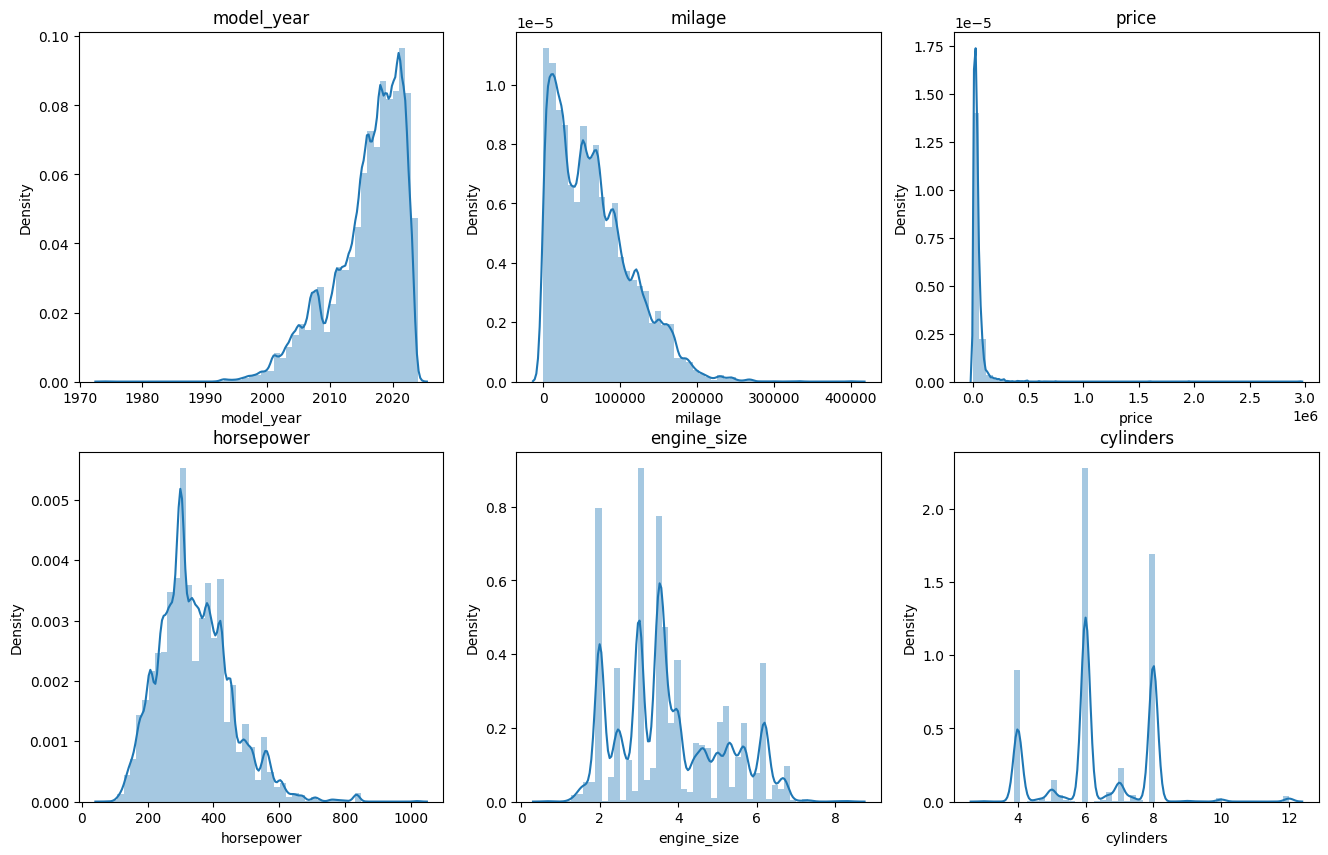

In [52]:
plt.figure(figsize=(16,10))
for i,col in enumerate(num_cols,1):
    plt.subplot(2,3,i)
    sns.distplot(df_train[col])
    plt.title(col)

In [53]:
df_train.describe()

,model_year,milage,price,horsepower,engine_size,cylinders
count,188533.000000,188533.000000,1.885330e+05,188533.00000,188533.000000,188533.000000
mean,2015.829998,65705.295174,4.387802e+04,343.11729,3.774957,6.371945
std,5.660967,49798.158076,7.881952e+04,109.73811,1.340617,1.477156
min,1974.000000,100.000000,2.000000e+03,70.00000,0.650000,3.000000
25%,2013.000000,24115.000000,1.700000e+04,268.00000,3.000000,6.000000
50%,2017.000000,57785.000000,3.082500e+04,332.00000,3.500000,6.000000
75%,2020.000000,95400.000000,4.990000e+04,411.00000,4.700000,8.000000
max,2024.000000,405000.000000,2.954083e+06,1020.00000,8.400000,12.000000


In [54]:
for col in num_cols:
    print(col, df_train[col].skew())

model_year -1.0445111735348063
milage 0.8950620098363095
price 20.268452710951134
horsepower 0.7813715591188364
engine_size 0.4830460303372587
cylinders 0.15158321360312013


In [55]:
X=df_train.drop(columns="price")
y=df_train["price"]

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [57]:
#  - High-cardinality categorical features: Target Encoding
te = TargetEncoder()
X_train[cat_cols]=te.fit_transform(X_train[cat_cols],y_train)
X_test[cat_cols]=te.transform(X_test[cat_cols])
df_test[cat_cols]=te.transform(df_test[cat_cols])

In [58]:
num_cols=X.select_dtypes(exclude="object").columns.values

scaler=RobustScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols])
X_test[num_cols]=scaler.transform(X_test[num_cols])
df_test[num_cols]=scaler.transform(df_test[num_cols])

In [59]:
X_train

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,horsepower,engine_size,cylinders
id,,,,,,,,,,,,,
101613,43782.444591,53205.140247,0.285714,-0.593866,43305.82681,60067.724858,40548.180617,45517.149048,49093.615351,63350.216773,-0.295775,0.529412,-0.500000
43431,43782.444591,60714.179102,-0.428571,0.543061,43305.82681,56438.970474,24010.571536,57640.008499,49093.615351,41327.065650,0.021127,-0.294118,0.000000
55159,52850.238381,47295.276310,0.285714,-0.098578,43305.82681,56438.970474,40678.427174,45517.149048,49093.615351,41327.065650,-0.598592,-0.882353,-1.000000
170448,41854.934939,47810.634061,0.571429,-0.307500,43305.82681,60067.724858,59512.602740,58350.640681,49093.615351,41327.065650,0.436620,-0.470588,-0.333333
95938,34491.361557,19829.489522,-0.285714,0.306615,43305.82681,31822.867166,40678.427174,28029.057346,25301.790486,41327.065650,-0.507042,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6518,51375.180630,65445.886486,0.571429,-0.631907,43305.82681,31822.867166,40678.427174,57640.008499,49093.615351,41327.065650,0.591549,0.294118,1.000000
159833,21544.985005,33113.861901,0.428571,-0.236319,43305.82681,25692.797357,42509.661234,46977.437245,49093.615351,41327.065650,-0.507042,-0.647059,-1.000000
177806,41100.395214,35017.602941,-0.428571,0.213444,43305.82681,46946.643722,48259.954220,45517.149048,49093.615351,41327.065650,0.007042,-0.294118,0.000000


In [60]:
params={
    'n_neighbors':(5,8,11),
    'weights':('uniform', 'distance'),
    'algorithm':('auto', 'ball_tree'),
    'leaf_size':(20,30,40),
    'p':(1,2,3)
    }

In [61]:
knn=KNeighborsRegressor()

In [62]:
clf = GridSearchCV(knn, params,cv=3, n_jobs=-1)

In [63]:
# clf.fit(X_train,y_train)

In [64]:
# best_params_knn= clf.best_estimator_.get_params()
best_params_knn = {
    'n_neighbors': 11,
    'weights':'uniform',
    'metric': 'minkowski',
    'algorithm':'ball_tree',
    'leaf_size': 30,
    'p':1
    }

In [65]:
best_params_knn

{'n_neighbors': 11,
 'weights': 'uniform',
 'metric': 'minkowski',
 'algorithm': 'ball_tree',
 'leaf_size': 30,
 'p': 1}

In [66]:
best_model_knn = KNeighborsRegressor(**best_params_knn)

In [67]:
best_model_knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11, p=1)

In [68]:
y_pred_knn=best_model_knn.predict(X_test)

In [69]:
print(f'RMSE_KNN:{np.sqrt(mean_squared_error(y_test, y_pred_knn))}, R2_KNN:{r2_score(y_test, y_pred_knn)}')

RMSE_KNN:81105.64080905648, R2_KNN:0.04959140672145901


In [70]:
y_df = best_model_knn.predict(df_test)
submission =pd.read_csv("sample_submission.csv",index_col="id")
submission["price"]=y_df.round(3)
submission.to_csv("knn_submission.csv")